# Portfolio Optimization
The goal is to optimize the portfolio using the Efficient Frontier. Namely, the goal is to select the best portfolio according to some criteria such as maximize return and reduce risk.

In [1]:
from pandas_datareader import data as web
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt

## Import Data from yahoo finance

In [2]:
#Get the stock simbols / tickers for the portfolio
assets = ["FB", "AMZN", "AAPL", "MSFT", "GOOG"]
#Get the portfolio starting date and ending date
stockStartDate = "2013-01-01"
stockEndDate = datetime.today().strftime("%Y-%m-%d")
#Create a Dataframe object to store the adjusted closed price of the stocks
df = pd.DataFrame()

#Store the adjusted close price of the stock into the df
for stock in assets:
    df[stock] = web.DataReader(stock, data_source='yahoo', start = stockStartDate, end = stockEndDate)['Adj Close']

df

,FB,AMZN,AAPL,MSFT,GOOG
Date,,,,,
2013-01-02,28.000000,257.309998,16.985447,23.030151,360.274597
2013-01-03,27.770000,258.480011,16.771048,22.721628,360.483826
2013-01-04,28.760000,259.149994,16.303904,22.296383,367.607117
2013-01-07,29.420000,268.459991,16.207993,22.254692,366.003143
2013-01-08,29.059999,266.380005,16.251612,22.137953,365.280823
...,...,...,...,...,...
2021-10-14,328.529999,3299.860107,143.759995,302.750000,2828.239990
2021-10-15,324.760010,3409.020020,144.839996,304.209991,2833.500000
2021-10-18,335.339996,3446.739990,146.550003,307.290009,2859.209961


## Data Visualization

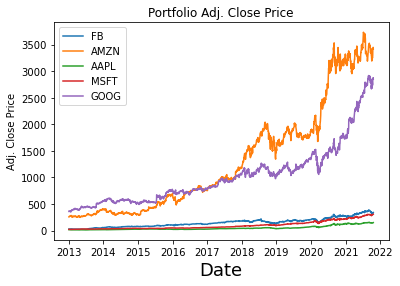

In [3]:
#Plot a graph
for i in df.columns.values:
    plt.plot(df[i], label = i)

plt.title("Portfolio Adj. Close Price")
plt.xlabel('Date', fontsize = 18)
plt.ylabel('Adj. Close Price')
plt.legend(df.columns.values, loc = 'upper left')
plt.show()

## Initial Portfolio
Here the variance of the portfolio is calculated: <br>
$ \sigma_p^2 = \textbf{W}^T \textbf{VW} = \sqrt{(w_i^2\sigma_i^2) + (w_j^2\sigma_j^2) + 2(w_iw_j\sigma_i \rho_{i,j}\sigma_j)}$ <br>
with W being the weights vector and V being the annualized variance covariance matrix 

In [4]:
#Risk free rate
rf = 0
# Log Returns
log_return = np.log(1 + df.pct_change())

# Assign initial equal weights to the stocks
n = len(assets)
weights = np.empty(n); weights.fill(1/n)

# Expected Returns Annualized (252 business days)
exp_ret = np.sum((log_return.mean() * weights) * 252)

# Annualized Covariance Matrix
log_ret_cov_M = log_return.cov() * 252

# Portfolio variance annualized
port_variance = np.dot(weights.T, np.dot(log_ret_cov_M, weights))

# Portfolio Volatility
port_vol = np.sqrt(port_variance)

# Sharpe Ratio
sharpe_ratio = (exp_ret - rf) / port_vol


#Put all into Dataframes

weights_df = pd.DataFrame(data = {
    'weights' : weights
    })
print('')
print("="*80)
print('Portfolio Weights')
print('-'*80)
print(weights_df)
print('-'*80)

metrics_df = pd.DataFrame(data = {
    'Expected Portfolio Returns': exp_ret,
    'Portfolio Volatility': port_vol,
    'Portfolio Sharpe Ratio': sharpe_ratio
}, index = [0])
print('')
print("="*80)
print('Portfolio Metrics')
print('-'*80)
print(metrics_df)
print('-'*80)


Portfolio Weights
--------------------------------------------------------------------------------
   weights
0      0.2
1      0.2
2      0.2
3      0.2
4      0.2
--------------------------------------------------------------------------------

Portfolio Metrics
--------------------------------------------------------------------------------
   Expected Portfolio Returns  Portfolio Volatility  Portfolio Sharpe Ratio
0                    0.271037              0.228849                1.184351
--------------------------------------------------------------------------------


## Optimization

Now we want to optimize the portfolio to get a better return with lower risk. <br>
First, the **Sharpe ratio** is used, in order to measure the risk adjusted return: <br>
<br>
$Sharpe Ratio = \frac{R_p-R_f}{\sigma_p}$ <br>
with: <br>
$R_p$ Return of portfolio<br>
$R_f$ Risk free rate<br>
$\sigma_p$ Standard Deviation of portfolio Excess Return<br>
<br>
In this case we see the return above the risk free rate, normalized by the risk.

In [5]:
import scipy.optimize as sci

Defining the function to be minimized

In [6]:
def negative_sharpe(weights: list) -> np.array:
    #Convert to numpy array
    weights = np.array(weights)
    
    # Expected Returns Annualized (252 business days)
    exp_ret = np.sum((log_return.mean() * weights) * 252)

    # Annualized Covariance Matrix
    log_ret_cov_M = log_return.cov() * 252

    # Portfolio variance annualized
    port_variance = np.dot(weights.T, np.dot(log_ret_cov_M, weights))

    # Portfolio Volatility
    port_vol = np.sqrt(port_variance)

    # Sharpe Ratio
    sharpe_ratio = (exp_ret - rf) / port_vol

    return -sharpe_ratio

def check_sum(weights: list) -> float:
    return np.sum(weights) - 1

In [23]:
# Define the bounds of the optimization process.
bounds = tuple((0,1) for i in range(n))

# Define the constraints make sure that the weights do not exceed 100%
constraints = ({'type': 'eq', 'fun': check_sum})

# Perform the optimization process
optimized_sharpe = sci.minimize(
    fun = negative_sharpe, #the function to minimize
    x0 = weights, #the starting values
    method = 'SLSQP',
    bounds = bounds,
    constraints = constraints
)
print('')
print("="*80)
print('Optimized Portfolio')
print('-'*80)
print(optimized_sharpe)
print('-'*80)


Optimized Portfolio
--------------------------------------------------------------------------------
     fun: -1.2297831005711155
     jac: array([ 5.62667847e-05, -1.00478530e-04, -9.83476639e-05,  5.81294298e-05,
       -2.37226486e-05])
 message: 'Optimization terminated successfully'
    nfev: 36
     nit: 6
    njev: 6
  status: 0
 success: True
       x: array([0.11420965, 0.24706747, 0.11595025, 0.51551539, 0.00725724])
--------------------------------------------------------------------------------


In [24]:
w = np.array(optimized_sharpe.x)
w = np.expand_dims(w, axis=0)
final_weights = pd.DataFrame(w, columns=df.columns.values)
final_weights

,FB,AMZN,AAPL,MSFT,GOOG
0,0.11421,0.247067,0.11595,0.515515,0.007257
